In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, linregress
import statsmodels.api as sm

In [47]:
N = 100000  # Total bison population
D = 2       # Average duration of infection (weeks)
rho = 0.1   # Ascertainment rate (10%)
Lifespan = 100
mu = 1 / Lifespan 
gamma = 1 / D 
gamma_plus_mu = gamma + mu

prevalence_sample_size = 1000
prevalence_cases = 7
seroprevalence_sample_size = 1000
seroprevalence_antibodies = 517

try:
    df = pd.read_csv('HW4_all_weeks.csv', header=None)
    df.columns = ['Week', 'Reported Cases']
except FileNotFoundError:
    print("ERROR: File 'HW4_all_weeks.csv' not found. Please ensure the file is in the correct directory.")
    raise FileNotFoundError("HW4_all_weeks.csv not found. Please ensure the file is in the correct directory.")

df['Reported Cases'] = pd.to_numeric(df['Reported Cases'], errors='coerce')

# Calculate True Incidence
df['I_true'] = df['Reported Cases'] / rho
df['ln_I_true'] = np.log(df['I_true'].replace(0, np.nan))

Combined Removal Rate (γ + μ): 0.5100 /week
Growth Slope (m): 0.0026 /week (95% CI: [0.0019, 0.0033])
Estimated R0: 1.0051
95% Confidence Interval for R0: [1.0037, 1.0065]


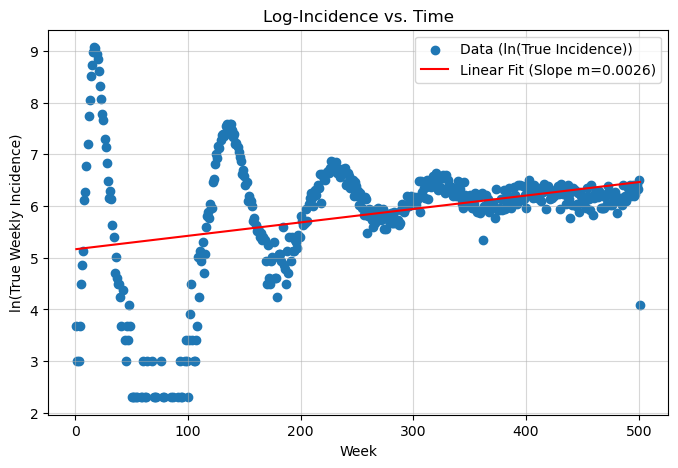

In [48]:
df_growth = df.dropna(subset=['ln_I_true']).copy()
df_growth['Week'] = pd.to_numeric(df_growth['Week'], errors='coerce')
df_growth = df_growth.dropna(subset=['Week']).copy()  # drop any non-numeric weeks
df_growth['Week'] = df_growth['Week'].astype(float)

X = sm.add_constant(df_growth['Week'])
y = df_growth['ln_I_true']

# Perform Ordinary Least Squares (OLS) regression using statsmodels for CI
model = sm.OLS(y, X).fit()
m_est = model.params['Week'] # This is the slope (lambda)
m_ci = model.conf_int(alpha=0.05).loc['Week'] # 95% CI for the slope

# R0 calculation: R0 = 1 + m / (gamma + mu)
R0_exp_growth = 1 + m_est / gamma_plus_mu
R0_exp_ci_low = 1 + m_ci[0] / gamma_plus_mu
R0_exp_ci_high = 1 + m_ci[1] / gamma_plus_mu
R0_exp_ci = (R0_exp_ci_low, R0_exp_ci_high)

print(f"Combined Removal Rate (γ + μ): {gamma_plus_mu:.4f} /week")
print(f"Growth Slope (m): {m_est:.4f} /week (95% CI: [{m_ci[0]:.4f}, {m_ci[1]:.4f}])")
print(f"Estimated R0: {R0_exp_growth:.4f}")
print(f"95% Confidence Interval for R0: [{R0_exp_ci[0]:.4f}, {R0_exp_ci[1]:.4f}]")

# Plotting (for visual work)
plt.figure(figsize=(8, 5))
plt.scatter(df_growth['Week'], df_growth['ln_I_true'], label='Data (ln(True Incidence))')
plt.plot(df_growth['Week'], model.predict(X), color='red', label=f'Linear Fit (Slope m={m_est:.4f})')
plt.title('Log-Incidence vs. Time')
plt.xlabel('Week')
plt.ylabel('ln(True Weekly Incidence)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.savefig('HW4_Graph1.png')
plt.show()

In [49]:
# Estimate Seroprevalence (phi) and its CI
phi_hat = seroprevalence_antibodies / seroprevalence_sample_size
n = seroprevalence_sample_size
z_025 = norm.ppf(0.975) # 1.96

SE_phi = np.sqrt((phi_hat * (1 - phi_hat)) / n)
CI_phi_low = phi_hat - z_025 * SE_phi
CI_phi_high = phi_hat + z_025 * SE_phi
CI_phi = (CI_phi_low, CI_phi_high)

print(f"Seroprevalence (phi_hat): {phi_hat:.4f} (95% CI: [{CI_phi_low:.4f}, {CI_phi_high:.4f}])")

# R0 calculation: R0 = -ln(1 - phi) / phi
def calculate_R0_fse(phi):
    if phi <= 0 or phi >= 1:
        return np.nan
    return -np.log(1 - phi) / phi

R0_fse = calculate_R0_fse(phi_hat)
R0_fse_ci_low = calculate_R0_fse(CI_phi_low)
R0_fse_ci_high = calculate_R0_fse(CI_phi_high)
R0_fse_ci = (R0_fse_ci_low, R0_fse_ci_high)

print(f"Estimated R0 (Final Size Equation): {R0_fse:.4f}")
print(f"95% Confidence Interval for R0: [{R0_fse_ci[0]:.4f}, {R0_fse_ci[1]:.4f}]")

Seroprevalence (phi_hat): 0.5170 (95% CI: [0.4860, 0.5480])
Estimated R0 (Final Size Equation): 1.4076
95% Confidence Interval for R0: [1.3694, 1.4490]


In [53]:
try:
    # Ensure these are 1D arrays so x and y used in plotting have matching shapes
    neg_controls = pd.read_csv('HW4_Q3_neg.csv', header=None).values.ravel()
    pos_controls = pd.read_csv('HW4_Q3_pos.csv', header=None).values.ravel()
    field_data = pd.read_csv('HW4_Q3_data.csv', header=None).values.ravel()
except FileNotFoundError as e:
    print(f"Error: Data file not found. Please ensure all three files are in the directory. Missing: {e}")
    
n_neg = len(neg_controls)
n_pos = len(pos_controls)
n_field = len(field_data)

def se(c, pos_data=pos_controls):
    """Sensitivity: P(Test+ | True+). Fraction of positive controls > cutoff c."""
    return np.sum(pos_data > c) / len(pos_data)

def sp(c, neg_data=neg_controls):
    """Specificity: P(Test- | True-). Fraction of negative controls <= cutoff c."""
    return np.sum(neg_data <= c) / len(neg_data)

def phi_hat(c, field_data=field_data):
    """Raw Prevalence: Observed fraction of positives in the field data."""
    return np.sum(field_data > c) / len(field_data)

def theta_hat(c, Se_c, Sp_c, phi_hat_c):
    """Corrected Prevalence (using Se and Sp at cutoff c)."""
    denominator = Se_c + Sp_c - 1
    if denominator <= 0:
        return np.nan 
    return (phi_hat_c - (1 - Sp_c)) / denominator

def youden_index(c):
    """Youden Index J = Se + Sp - 1. We maximize J."""
    return se(c) + sp(c) - 1

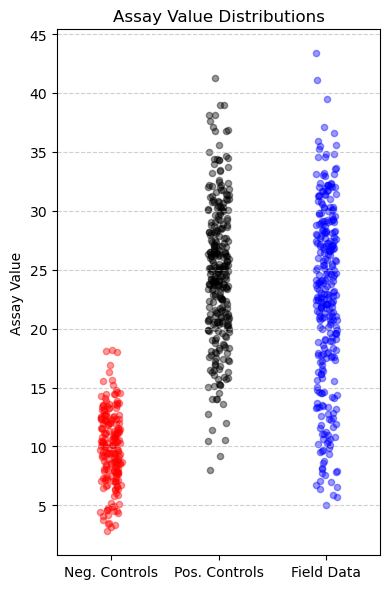

In [54]:
plt.figure(figsize=(4, 6))

# Plot Negative Controls (Red)
plt.scatter(
    np.zeros_like(neg_controls) + np.random.uniform(-0.1, 0.1, n_neg),
    neg_controls,
    color='red',
    alpha=0.4,
    s=20,
    label='Negative Controls'
)

# Plot Positive Controls (Black)
plt.scatter(
    np.ones_like(pos_controls) + np.random.uniform(-0.1, 0.1, n_pos),
    pos_controls,
    color='black',
    alpha=0.4,
    s=20,
    label='Positive Controls'
)

# Plot Field Data (Blue)
plt.scatter(
    np.ones_like(field_data) * 2 + np.random.uniform(-0.1, 0.1, n_field),
    field_data,
    color='blue',
    alpha=0.4,
    s=20,
    label='Field Data'
)

# Formatting
plt.xticks([0, 1, 2], ['Neg. Controls', 'Pos. Controls', 'Field Data'])
plt.ylabel('Assay Value')
plt.title('Assay Value Distributions')
plt.xlim(-0.5, 2.5)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('HW4_Graph 2.png')
plt.show()

In [57]:
# Sweep over a relevant range of cutoffs
min_val = min(neg_controls.min(), pos_controls.min())
max_val = max(neg_controls.max(), pos_controls.max())
c_values = np.linspace(min_val, max_val, 500)

# Calculate Youden index for each cutoff
youden_values = [youden_index(c) for c in c_values]

# The Youden choice is the cutoff c that maximizes the Youden index
c_youden = c_values[np.argmax(youden_values)]
max_youden_J = np.max(youden_values)

# Calculate final metrics at Youden cutoff
Se_youden = se(c_youden)
Sp_youden = sp(c_youden)
phi_youden = phi_hat(c_youden)
theta_youden = theta_hat(c_youden, Se_youden, Sp_youden, phi_youden)

print(f"Optimal Cutoff (c_Y): {c_youden:.4f}")
print(f"Sensitivity at c_Y: {Se_youden:.4f}")
print(f"Specificity at c_Y: {Sp_youden:.4f}")
print(f"Raw Prevalence at c_Y (phi_hat): {phi_youden:.4f}")
print(f"Corrected Prevalence at c_Y (theta_hat): {theta_youden:.4f}")


Optimal Cutoff (c_Y): 14.8290
Sensitivity at c_Y: 0.9600
Specificity at c_Y: 0.9600
Raw Prevalence at c_Y (phi_hat): 0.8067
Corrected Prevalence at c_Y (theta_hat): 0.8333


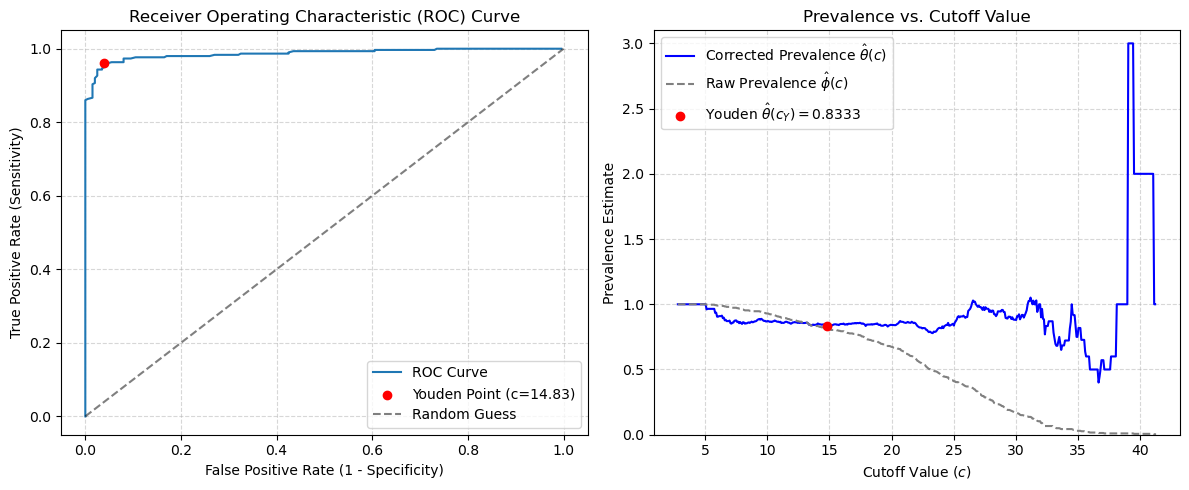

In [56]:
# Calculate metrics for all cutoffs
Se_list = [se(c) for c in c_values]
Sp_list = [sp(c) for c in c_values]
FPR_list = [1 - Sp_c for Sp_c in Sp_list] # False Positive Rate (FPR) = 1 - Specificity

# Corrected Prevalence for all cutoffs
theta_list = [theta_hat(c, Se_c, Sp_c, phi_hat(c)) for c, Se_c, Sp_c in zip(c_values, Se_list, Sp_list)]

plt.figure(figsize=(12, 5))

# Plot 1: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(FPR_list, Se_list, label='ROC Curve')
plt.scatter(1 - Sp_youden, Se_youden, color='red', marker='o', 
            label=f'Youden Point (c={c_youden:.2f})', zorder=5)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Guess')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)

# Plot 2: Corrected Prevalence vs. Cutoff
plt.subplot(1, 2, 2)
plt.plot(c_values, theta_list, label='Corrected Prevalence $\\hat{\\theta}(c)$', color='blue')
# Add Raw Prevalence for comparison
plt.plot(c_values, [phi_hat(c) for c in c_values], label='Raw Prevalence $\\hat{\\phi}(c)$', color='gray', linestyle='--')
plt.scatter(c_youden, theta_youden, color='red', marker='o', 
            label=f'Youden $\\hat{{\\theta}}(c_Y)={theta_youden:.4f}$', zorder=5)
plt.xlabel('Cutoff Value ($c$)')
plt.ylabel('Prevalence Estimate')
plt.title('Prevalence vs. Cutoff Value')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.ylim(min(0, np.nanmin(theta_list) - 0.1), max(1, np.nanmax(theta_list) + 0.1)) # Adjust y-limits
plt.tight_layout()
plt.savefig('HW4_Graph3.png')
plt.show()